In [ ]:
!pip install mediapipe opencv-python scikit-learn pandas tqdm tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing inst

In [ ]:
# Step 1: Upload your kaggle.json file to Colab
from google.colab import files
files.upload()   # Upload your kaggle.json file when prompted

# Step 2: Create .kaggle directory and move the config file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Step 3: Install the Kaggle package
!pip install kaggle
!pip install kagglehub

Saving kaggle.json to kaggle.json


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imsparsh/gesture-recognition")

print("Path to dataset files:", path)

100%|██████████| 1.60G/1.60G [00:23<00:00, 73.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2


In [ ]:
# Cell 4: Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 2: Import Libraries and Setup
import cv2
import numpy as np
import os
import mediapipe as mp
from tqdm import tqdm
import logging
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


In [ ]:
# Cell 3: Initialize MediaPipe and Define Constants
# Define selected classes only (2, 3, 4)
CLASS_MAPPING = {
    #0: 'Left Swipe',
    #1: 'Right Swipe',
    2: 'Stop',
    3: 'Thumbs Down',
    4: 'Thumbs Up'
}
TARGET_SEQUENCES_PER_CLASS = 120
NUM_FRAMES = 30  # Number of frames per sequence
NUM_LANDMARKS = 21 * 3  # 21 landmarks × (x,y,z)

In [ ]:
mp_hands = mp.solutions.hands

def extract_landmarks_from_frame(frame, hands_detector):
    results = hands_detector.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        hand = results.multi_hand_landmarks[0]
        return np.array([[lm.x, lm.y, lm.z] for lm in hand.landmark]).flatten()
    else:
        return np.zeros(NUM_LANDMARKS)

def process_sequence_folder(folder_path, hands_detector):
    frame_files = sorted(os.listdir(folder_path))
    sequence = []

    for frame_file in frame_files[:NUM_FRAMES]:
        frame_path = os.path.join(folder_path, frame_file)
        frame = cv2.imread(frame_path)

        if frame is None:
            sequence.append(np.zeros(NUM_LANDMARKS))
            continue

        lm = extract_landmarks_from_frame(frame, hands_detector)
        sequence.append(lm)

    # Pad or trim
    if len(sequence) < NUM_FRAMES:
        for _ in range(NUM_FRAMES - len(sequence)):
            sequence.append(np.zeros(NUM_LANDMARKS))
    elif len(sequence) > NUM_FRAMES:
        sequence = sequence[:NUM_FRAMES]

    return np.stack(sequence)

In [ ]:
# --- Paths ---
CSV_PATH = "/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/train.csv"
DATASET_PATH = "/root/.cache/kagglehub/datasets/imsparsh/gesture-recognition/versions/2/train"

# --- Load CSV ---
df = pd.read_csv(CSV_PATH, sep=';', header=None, names=['folder', 'class', 'label'])

print("Loaded CSV data:")
print(f"Total entries: {len(df)}")
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print("\nOriginal label distribution:")
print(df['label'].value_counts().sort_index())

# --- Balance Helper ---
def balance_dataset(df):
    """Filter only classes 2, 3, 4 and limit to TARGET_SEQUENCES_PER_CLASS each"""
    selected_df = df[df['label'].isin(CLASS_MAPPING.keys())]
    balanced_df = pd.DataFrame()

    for class_idx in CLASS_MAPPING.keys():
        class_data = selected_df[selected_df['label'] == class_idx]
        if len(class_data) > TARGET_SEQUENCES_PER_CLASS:
            class_data = class_data.sample(n=TARGET_SEQUENCES_PER_CLASS, random_state=42)
        balanced_df = pd.concat([balanced_df, class_data])

    balanced_df = shuffle(balanced_df, random_state=42).reset_index(drop=True)

    print("\nBalanced label distribution:")
    print(balanced_df['label'].value_counts().sort_index())

    return balanced_df

# --- Apply balance ---
balanced_df = balance_dataset(df)


Loaded CSV data:
Total entries: 663

Columns: ['folder', 'class', 'label']

First few rows:
                                     folder           class  label
0  WIN_20180925_17_08_43_Pro_Left_Swipe_new  Left_Swipe_new      0
1  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new      0
2  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new      0
3  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new      0
4  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new      0

Original label distribution:
label
0    136
1    137
2    130
3    137
4    123
Name: count, dtype: int64

Balanced label distribution:
label
2    120
3    120
4    120
Name: count, dtype: int64


In [ ]:
X_train = []
y_train = []

with mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5) as hands_detector:
    for idx, row in tqdm(balanced_df.iterrows(), total=len(balanced_df), desc="Processing sequences"):
        folder_name = row['folder']
        label = int(row['label'])
        folder_path = os.path.join(DATASET_PATH, folder_name)

        if not os.path.isdir(folder_path):
            print(f"Warning: Folder {folder_path} does not exist, skipping.")
            continue

        sequence = process_sequence_folder(folder_path, hands_detector)
        X_train.append(sequence)
        y_train.append(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print("\nData shapes:", X_train.shape, y_train.shape)
print("Unique labels before remap:", np.unique(y_train))

# --- Remap labels [2,3,4] → [0,1,2] ---
label_mapping = {2: 0, 3: 1, 4: 2}
y_train = np.array([label_mapping[label] for label in y_train])

print("Unique labels after remap:", np.unique(y_train))

# --- Save preprocessed data ---
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)

print("Saved X_train.npy and y_train.npy")


Processing sequences: 100%|██████████| 360/360 [08:00<00:00,  1.34s/it]


Data shapes: (360, 30, 63) (360,)
Unique labels before remap: [2 3 4]
Unique labels after remap: [0 1 2]
✅ Saved X_train.npy and y_train.npy


In [ ]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# --- Load ---
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")

print("Loaded shapes:")
print("X:", X_train.shape)
print("y:", y_train.shape)
print("Unique labels before remap:", np.unique(y_train))

# --- One-hot encode ---
y_categorical = to_categorical(y_train, num_classes=3)

print("One-hot shape:", y_categorical.shape)

# --- Train-test split ---
from sklearn.model_selection import train_test_split

X_train_split, X_test, y_train_split, y_test = train_test_split(
    X_train, y_categorical, test_size=0.3, random_state=42, stratify=y_categorical,
)

print(f"Train X: {X_train_split.shape}  y: {y_train_split.shape}")
print(f"Test  X: {X_test.shape}  y: {y_test.shape}")


Loaded shapes:
X: (360, 30, 63)
y: (360,)
Unique labels before remap: [0 1 2]
One-hot shape: (360, 3)
Train X: (252, 30, 63)  y: (252, 3)
Test  X: (108, 30, 63)  y: (108, 3)


In [ ]:
# Build LSTM model
model = Sequential([
    # 1st LSTM Layer
    LSTM(128, return_sequences=True, activation='tanh',
         input_shape=(NUM_FRAMES, 63)),  # 30 frames, 63 features per frame
    Dropout(0.5),
    #BatchNormalization(),

    # 2nd LSTM Layer
    LSTM(64, return_sequences=False, activation='tanh'),
    Dropout(0.5),
    #BatchNormalization(),

    # Dense Layers
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,067 (594.01 KB)

 Trainable params: 152,067 (594.01 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
callbacks = [
    ModelCheckpoint(
        'Best_3 Gesture Mediapipe LSTM.h5',
        save_best_only=True,
        monitor='val_loss',
        verbose=1
    )
]

# Train model
history = model.fit(
    X_train_split,
    y_train_split,
    validation_split=0.2,
    batch_size=16,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3581 - loss: 1.1040
Epoch 1: val_loss improved from inf to 1.07423, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3589 - loss: 1.1044 - val_accuracy: 0.4706 - val_loss: 1.0742
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3795 - loss: 1.0894
Epoch 2: val_loss improved from 1.07423 to 1.05889, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.3808 - loss: 1.0884 - val_accuracy: 0.4118 - val_loss: 1.0589
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3356 - loss: 1.0775
Epoch 3: val_loss improved from 1.05889 to 1.04230, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.3422 - loss: 1.0761 - val_accuracy: 0.3333 - val_loss: 1.0423
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4503 - loss: 1.0508
Epoch 4: val_loss improved from 1.04230 to 1.00212, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.4515 - loss: 1.0502 - val_accuracy: 0.4902 - val_loss: 1.0021
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5435 - loss: 1.0066
Epoch 5: val_loss improved from 1.00212 to 0.95447, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5420 - loss: 1.0071 - val_accuracy: 0.6275 - val_loss: 0.9545
Epoch 6/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6115 - loss: 0.9805
Epoch 6: val_loss improved from 0.95447 to 0.90249, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6144 - loss: 0.9794 - val_accuracy: 0.6275 - val_loss: 0.9025
Epoch 7/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6983 - loss: 0.8982
Epoch 7: val_loss improved from 0.90249 to 0.82906, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6952 - loss: 0.8999 - val_accuracy: 0.7451 - val_loss: 0.8291
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7418 - loss: 0.8613
Epoch 8: val_loss improved from 0.82906 to 0.74929, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7404 - loss: 0.8602 - val_accuracy: 0.7451 - val_loss: 0.7493
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.7668 - loss: 0.8070
Epoch 9: val_loss improved from 0.74929 to 0.67576, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.7682 - loss: 0.8045 - val_accuracy: 0.7255 - val_loss: 0.6758
Epoch 10/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.7577 - loss: 0.7510
Epoch 10: val_loss improved from 0.67576 to 0.59566, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7611 - loss: 0.7447 - val_accuracy: 0.7843 - val_loss: 0.5957
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7752 - loss: 0.6451
Epoch 11: val_loss improved from 0.59566 to 0.51912, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7774 - loss: 0.6445 - val_accuracy: 0.8824 - val_loss: 0.5191
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8772 - loss: 0.5333
Epoch 12: val_loss improved from 0.51912 to 0.44719, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.8753 - loss: 0.5339 - val_accuracy: 0.8824 - val_loss: 0.4472
Epoch 13/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9044 - loss: 0.4772
Epoch 13: val_loss improved from 0.44719 to 0.40043, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9046 - loss: 0.4725 - val_accuracy: 0.8824 - val_loss: 0.4004
Epoch 14/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.8933 - loss: 0.4150
Epoch 14: val_loss improved from 0.40043 to 0.31775, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8924 - loss: 0.4154 - val_accuracy: 0.9412 - val_loss: 0.3178
Epoch 15/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8982 - loss: 0.4367
Epoch 15: val_loss did not improve from 0.31775
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9006 - loss: 0.4292 - val_accuracy: 0.9020 - val_loss: 0.3792
Epoch 16/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9722 - loss: 0.2649
Epoch 16: val_loss did not improve from 0.31775
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9713 - loss: 0.2679 - val_accuracy: 0.8627 - val_loss: 0.3608
Epoch 17/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9172 - loss: 0.3078
Epoch 17: val_loss did not improve from 0.31775
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9241 - loss: 0.3015 - val_accuracy: 0.9216 - val_loss: 0.3422
Epoch 18/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9508 - loss: 0.2659
Epoch 18: val_loss improved from 0.31775 to 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9504 - loss: 0.2656 - val_accuracy: 0.9216 - val_loss: 0.2491
Epoch 19/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9610 - loss: 0.2456
Epoch 19: val_loss improved from 0.24908 to 0.24502, saving model to standard_lstm_model_3classes.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9616 - loss: 0.2446 - val_accuracy: 0.9216 - val_loss: 0.2450
Epoch 20/100
12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9647 - loss: 0.2112
Epoch 20: val_loss did not improve from 0.24502
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9662 - loss: 0.2109 - val_accuracy: 0.9216 - val_loss: 0.2472
Epoch 21/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9975 - loss: 0.1666
Epoch 21: val_loss did not improve from 0.24502
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.9966 - loss: 0.1667 - val_accuracy: 0.9412 - val_loss: 0.2495
Epoch 22/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9421 - loss: 0.2289
Epoch 22: val_loss did not improve from 0.24502
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9431 - loss: 0.2287 - val_accuracy: 0.9020 - val_loss: 0.2937
Epoch 23/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9687 - loss: 0.1845
Epoch 23: val_loss did not improve from 0.24

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 0.0074

Test Accuracy: 100.00%


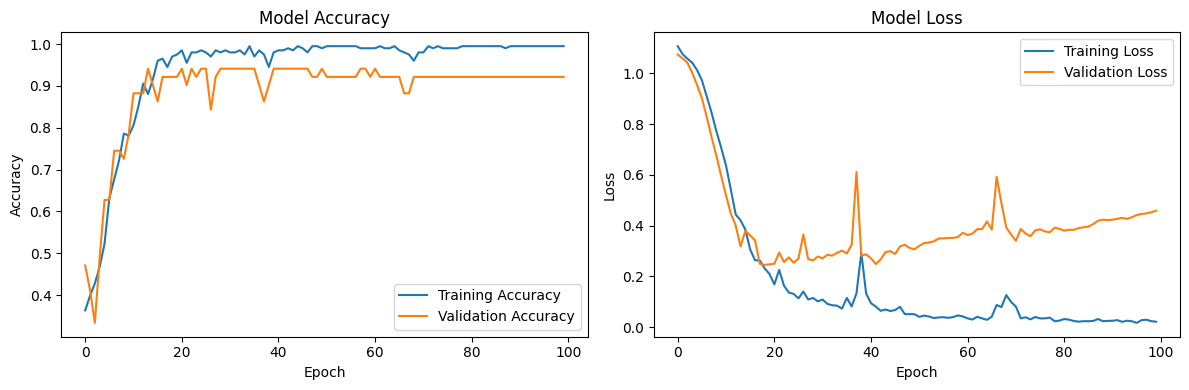

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()
